# Week 5

Hidden Markov Models

Krzysztof Kowalczyk (kk385830)

In [1]:
import gzip
import requests
import shutil

In [2]:
def download_gz(url, target_file):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(target_file, 'wb') as f:
            r.raw.decode_content = True  # just in case transport encoding was applied
            gzip_file = gzip.GzipFile(fileobj=r.raw)
            shutil.copyfileobj(gzip_file, f)

In [3]:
download_gz('http://regulomics.mimuw.edu.pl/wp/wp-content/uploads/2018/04/cpg.fa_.gz', 'data/cpg.fa')
download_gz('http://regulomics.mimuw.edu.pl/wp/wp-content/uploads/2018/04/cpg_test.fa_.gz', 'data/cpg_test.fa')

## Reading data

In [4]:
from Bio import SeqIO
from dataclasses import dataclass
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [5]:
@dataclass
class ModelSeq(object):
    label: str
    seq: str
    
    def as_array(self, k_nucleotides: int=1) -> np.array:
        return np.array([
            self.seq[i:i+k_nucleotides] 
            for i in range(0, len(self.seq) // k_nucleotides, k_nucleotides)
        ])

def load_seq(path):
    return [
        ModelSeq(seq_data.description, str(seq_data.seq)) 
        for seq_data in SeqIO.parse(path, format='fasta')
    ]

train_seqs = load_seq('data/cpg.fa')
test_seqs =  load_seq('data/cpg_test.fa')
print(f"training sequences: {len(train_seqs)}, test sequences: {len(test_seqs)}")

training sequences: 1, test sequences: 30


In [6]:
encoder = LabelEncoder()
train_arr = train_seqs[0].as_array(k_nucleotides=2)
train = encoder.fit_transform(train_arr).reshape((-1,1))
labels = encoder.classes_
print(labels)
assert(len(labels) == 16)  # makes sure all classes are present

['AA' 'AC' 'AG' 'AT' 'CA' 'CC' 'CG' 'CT' 'GA' 'GC' 'GG' 'GT' 'TA' 'TC'
 'TG' 'TT']


## Training the model

In [7]:
from hmmlearn import hmm

In [8]:
train_samples = int(len(train) * 0.75)
train_ = train[:train_samples]
eval_ = train[train_samples:]
n_components = 2

In [9]:
%%time
model = hmm.GaussianHMM(n_components=n_components)
model.fit(train_)

Wall time: 23.9 s


## Interpret HMM states

We need to know which state corresponds to CpG island.
To do this, we will check relationship between class probabilities and number of CGs in the various parts of evaluation set.

In [10]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
CG_idxs = eval_[:,0] == np.argmax(labels == 'CG')
rows = []
for i, eval_batch_ in enumerate([eval_[CG_idxs,:], eval_[~CG_idxs,:]]):
    CG_count = np.sum(eval_batch_ == np.argmax(labels == 'CG'))
    states = model.predict(eval_batch_)
    class_count = {
        f"Class_{i}_count": np.sum(states == i) / len(states)
        for i in range(n_components)
    }
    rows.append(pd.DataFrame({'CG_count': CG_count, **class_count}, index=[i]))
eval_results = pd.concat(rows, axis='index')

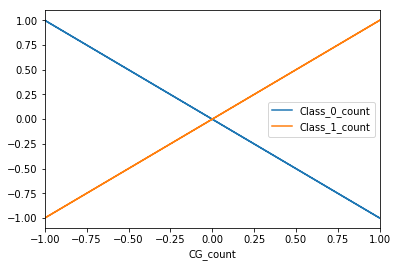

In [12]:
eval_results.corr().plot(x='CG_count')
plt.show()

In [13]:
CG_class = eval_results.corr()['CG_count'].iloc[1:].values.argmax()
print(f"Based on evaluation set, we assume class {CG_class} corresponds to CpG island.")

Based on evaluation set, we assume class 1 corresponds to CpG island.


## Generating predictions

(home assignment)

In [14]:
rows = []
for i, ts in tqdm(enumerate(test_seqs)):
    test = encoder.transform(ts.as_array(k_nucleotides=2)).reshape((-1,1))
    states = model.predict(test)
    is_cpg = np.sum(states == CG_class) >= (len(states) / 2)
    rows.append(pd.DataFrame({'seq_name': ts.label, 'is_cpg_island': is_cpg}, index=[i]))
results = pd.concat(rows)
results.to_csv('data/cpg_islands_kk385830.csv')
print(results)

30it [00:00, 291.24it/s]


                      seq_name  is_cpg_island
0    Seq 0 testing cpg islands          False
1    Seq 1 testing cpg islands           True
2    Seq 2 testing cpg islands           True
3    Seq 3 testing cpg islands           True
4    Seq 4 testing cpg islands          False
5    Seq 5 testing cpg islands           True
6    Seq 6 testing cpg islands           True
7    Seq 7 testing cpg islands          False
8    Seq 8 testing cpg islands           True
9    Seq 9 testing cpg islands          False
10  Seq 10 testing cpg islands           True
11  Seq 11 testing cpg islands           True
12  Seq 12 testing cpg islands           True
13  Seq 13 testing cpg islands          False
14  Seq 14 testing cpg islands          False
15  Seq 15 testing cpg islands          False
16  Seq 16 testing cpg islands          False
17  Seq 17 testing cpg islands          False
18  Seq 18 testing cpg islands          False
19  Seq 19 testing cpg islands           True
20  Seq 20 testing cpg islands    